<a href="https://colab.research.google.com/github/Devlaxman93/Neurohackers/blob/experimental-code/Steinmetz_SC_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import os, sys
# from google.colab import drive
# drive.mount('/content/drive')
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/notebooks', nb_path)
# sys.path.insert(0,nb_path)

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# installs package permanently on Google drive
# !pip install --target=$nb_path git+https://github.com/ahwillia/tensortools

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import tensortools as tt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


In [ ]:
response_dict = {'right': -1, 'nogo': 0, 'left': 1}

In [ ]:
# filtering data by desired brain region:
# only trials with correct response are included 
# minimum number of correct trials: 180
# data is smoothed with Gaussian filter of 1.5 SD
def tca_by_region (region, min_trials = 180, window = 1.5):
  smoothed_dat = []
  mouse_names = np.array([])
  for i in range(alldata.shape[0]):
    area = alldata[i]['brain_area']
    response = alldata[i]['response'] # right - nogo - left (-1, 0, 1)
    vis_right = alldata[i]['contrast_right'] # 0 - low - high
    vis_left = alldata[i]['contrast_left'] # 0 - low - high
    is_correct = np.sign(response)==np.sign(vis_left-vis_right) 
    f_dat = alldata[i]['spks'][area==region][:, is_correct, :]
    print(f"session {i+1}: data dimensions: {f_dat.shape}")
    # print(f_dat.shape)
    if (f_dat.shape[0] > 0) and (f_dat.shape[1] >= min_trials):
      f_dat = f_dat[:, :min_trials, :]
      mouse_name = np.repeat(alldata[i]['mouse_name'], f_dat.shape[0])
      mouse_names = np.concatenate((mouse_names, mouse_name))
    # finds SD of each neuron and applies Gaussian filter
      for j in range(f_dat.shape[0]):
        sd = np.std(f_dat[j]) * window
        f_dat_smooth = gaussian_filter1d(f_dat[j], sigma=sd, axis=-1)[np.newaxis, :]
        smoothed_dat.append(f_dat_smooth)
  joint_array = np.vstack(smoothed_dat)
  print(f"final array {joint_array.shape}")
  return joint_array, mouse_names

In [ ]:
# modified function to fit only a single session
def tca_by_region_session (data, region, window = 1.5):
  response_dict = {-1: 'right', 0: 'nogo', 1: 'left'}
  smoothed_dat = []
  area = data['brain_area']
  response = data['response'] # right - nogo - left (-1, 0, 1)
  vis_right = data['contrast_right'] # 0 - low - high
  vis_left = data['contrast_left'] # 0 - low - high
  is_correct = np.sign(response)==np.sign(vis_left-vis_right)
  # returns a list of responses for correct trials 
  corr_response = response[is_correct].tolist()
  corr_response = [response_dict[r] for r in corr_response]
  f_dat = data['spks'][area==region][:, is_correct, :]
  print(f"data dimensions: {f_dat.shape}")
  # print(f_dat.shape)
  if (f_dat.shape[0] > 0):
  # finds SD of each neuron and applies Gaussian filter
    for j in range(f_dat.shape[0]):
      sd = np.std(f_dat[j]) * window
      f_dat_smooth = gaussian_filter1d(f_dat[j], sigma=sd, axis=-1)[np.newaxis, :]
      smoothed_dat.append(f_dat_smooth)
  joint_array = np.vstack(smoothed_dat)
  print(f"final array {joint_array.shape}")
  return joint_array, corr_response

In [ ]:
# SCs
joint_array_SCs, mice_SCs = tca_by_region("SCs")
print(joint_array_SCs.shape)

session 1: data dimensions: (0, 139, 250)
session 2: data dimensions: (0, 151, 250)
session 3: data dimensions: (0, 140, 250)
session 4: data dimensions: (0, 167, 250)
session 5: data dimensions: (0, 157, 250)
session 6: data dimensions: (0, 205, 250)
session 7: data dimensions: (0, 162, 250)
session 8: data dimensions: (0, 158, 250)
session 9: data dimensions: (0, 254, 250)
session 10: data dimensions: (0, 273, 250)
session 11: data dimensions: (0, 261, 250)
session 12: data dimensions: (0, 236, 250)
session 13: data dimensions: (32, 230, 250)
session 14: data dimensions: (37, 181, 250)
session 15: data dimensions: (0, 299, 250)
session 16: data dimensions: (0, 195, 250)
session 17: data dimensions: (0, 178, 250)
session 18: data dimensions: (0, 241, 250)
session 19: data dimensions: (0, 145, 250)
session 20: data dimensions: (0, 134, 250)
session 21: data dimensions: (0, 69, 250)
session 22: data dimensions: (0, 290, 250)
session 23: data dimensions: (0, 100, 250)
session 24: data di

In [ ]:
# VISam
joint_array_VISam, mice_VISam = tca_by_region("VISam", min_trials=200)

session 1: data dimensions: (0, 139, 250)
session 2: data dimensions: (0, 151, 250)
session 3: data dimensions: (114, 140, 250)
session 4: data dimensions: (0, 167, 250)
session 5: data dimensions: (0, 157, 250)
session 6: data dimensions: (0, 205, 250)
session 7: data dimensions: (0, 162, 250)
session 8: data dimensions: (0, 158, 250)
session 9: data dimensions: (38, 254, 250)
session 10: data dimensions: (0, 273, 250)
session 11: data dimensions: (0, 261, 250)
session 12: data dimensions: (79, 236, 250)
session 13: data dimensions: (34, 230, 250)
session 14: data dimensions: (0, 181, 250)
session 15: data dimensions: (0, 299, 250)
session 16: data dimensions: (0, 195, 250)
session 17: data dimensions: (0, 178, 250)
session 18: data dimensions: (0, 241, 250)
session 19: data dimensions: (111, 145, 250)
session 20: data dimensions: (0, 134, 250)
session 21: data dimensions: (0, 69, 250)
session 22: data dimensions: (0, 290, 250)
session 23: data dimensions: (190, 100, 250)
session 24: 

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/filters.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  phi_x = numpy.exp(-0.5 / sigma2 * x ** 2)
/usr/local/lib/python3.6/dist-packages/scipy/ndimage/filters.py:145: RuntimeWarning: invalid value encountered in multiply
  phi_x = numpy.exp(-0.5 / sigma2 * x ** 2)


session 39: data dimensions: (126, 246, 250)
final array (352, 200, 250)


The TCA fitting method returns a list of factor weights in the attribute of the returned object `*.factors[ndim, rank]` as a list of three matrices, the 0th element of the list are subject weights, the 1st element are trial weights and the 2nd element are time weights. 

CP_ALS: iteration 1, objective 0.9981582953133011, improvement inf.
CP_ALS: iteration 2, objective 0.9809346006959638, improvement 0.017223694617337304.
CP_ALS: iteration 3, objective 0.977746374739441, improvement 0.0031882259565227944.
CP_ALS: iteration 4, objective 0.9765374097559885, improvement 0.0012089649834525762.
CP_ALS: iteration 5, objective 0.9759631626647863, improvement 0.0005742470912021291.
CP_ALS: iteration 6, objective 0.9756849501189714, improvement 0.0002782125458149487.
CP_ALS: iteration 7, objective 0.9755328146170844, improvement 0.0001521355018869741.
CP_ALS: iteration 8, objective 0.9754395892432588, improvement 9.322537382561169e-05.
CP_ALS: iteration 9, objective 0.9753785583075165, improvement 6.103093574227891e-05.
CP_ALS: iteration 10, objective 0.9753372626515329, improvement 4.1295655983653035e-05.
CP_ALS: iteration 11, objective 0.9753088071397326, improvement 2.8455511800307143e-05.
CP_ALS: iteration 12, objective 0.9752889648121411, improvement 1.9842

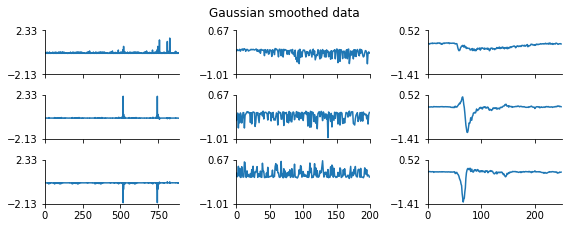

In [ ]:
# TCA decomposition of the data: SCs
R = 4
U_SCs = tt.cp_als(joint_array_SCs, rank=R, verbose=True)
fig, ax, po = tt.plot_factors(U.factors)
fig.figsize=(12,10)
fig.suptitle("Gaussian smoothed data",y=1.04)
fig.tight_layout()

In [ ]:
# TCA decomposition of the data: VISam
R = 3
U_VISam = tt.cp_als(joint_array_VISam, rank=R, verbose=True)

CP_ALS: iteration 1, objective 0.9986674154548291, improvement inf.
CP_ALS: iteration 2, objective 0.9885553095703575, improvement 0.010112105884471534.
CP_ALS: iteration 3, objective 0.9825983576400878, improvement 0.005956951930269683.
CP_ALS: iteration 4, objective 0.9801231771725255, improvement 0.0024751804675623434.
CP_ALS: iteration 5, objective 0.9794118678565805, improvement 0.0007113093159449857.
CP_ALS: iteration 6, objective 0.9791213926446367, improvement 0.0002904752119438081.
CP_ALS: iteration 7, objective 0.9790015026216253, improvement 0.00011989002301138196.
CP_ALS: iteration 8, objective 0.9789299434564009, improvement 7.155916522438854e-05.
CP_ALS: iteration 9, objective 0.9788651640295265, improvement 6.47794268744395e-05.
CP_ALS: iteration 10, objective 0.9787936848516282, improvement 7.147917789829261e-05.
CP_ALS: iteration 11, objective 0.9787150764344905, improvement 7.860841713769329e-05.
CP_ALS: iteration 12, objective 0.9786367510932609, improvement 7.832534

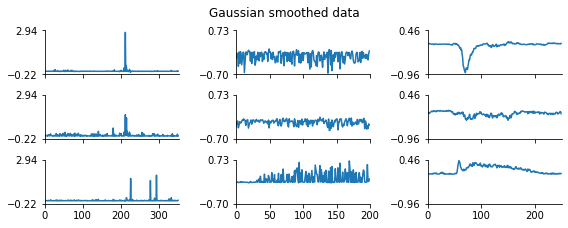

In [ ]:
fig, ax, po = tt.plot_factors(U_VISam.factors)
fig.figsize=(20,16)
fig.suptitle("Gaussian smoothed data",y=1.04)
fig.tight_layout()

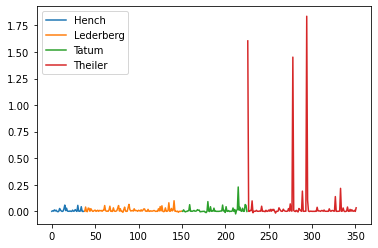

In [ ]:
cmap = plt.get_cmap('viridis')
# print(U_VISam.factors[0][:, 0].shape)
# print(len(mice_VISam))
# print(np.arange(U_VISam.factors[0][:, 0].shape[0]))
sns.lineplot(x = np.arange(U_VISam.factors[0][:,2].shape[0]), y = U_VISam.factors[0][:, 2], hue = mice_VISam)
# plt.plot(U_VISam.factors[0][0,:], c=mice_VISam)
# plt.show()

In [ ]:
# just session 39 data for VISam
joint_array_VISam_39, responses_VISam_39 = tca_by_region_session(alldat[38], "VISam")

data dimensions: (126, 246, 250)
final array (126, 246, 250)
['left', 'right', 'right', 'left', 'nogo', 'right', 'right', 'nogo', 'right', 'right', 'left', 'right', 'right', 'right', 'right', 'left', 'right', 'right', 'nogo', 'right', 'left', 'right', 'nogo', 'left', 'left', 'right', 'left', 'nogo', 'nogo', 'right', 'right', 'left', 'right', 'right', 'left', 'left', 'right', 'nogo', 'left', 'right', 'left', 'nogo', 'right', 'nogo', 'left', 'right', 'nogo', 'nogo', 'right', 'left', 'left', 'left', 'nogo', 'right', 'nogo', 'right', 'nogo', 'left', 'right', 'left', 'left', 'right', 'left', 'right', 'nogo', 'nogo', 'nogo', 'right', 'nogo', 'nogo', 'right', 'nogo', 'nogo', 'nogo', 'nogo', 'left', 'left', 'left', 'nogo', 'right', 'nogo', 'nogo', 'left', 'left', 'nogo', 'right', 'nogo', 'right', 'right', 'right', 'right', 'right', 'left', 'nogo', 'right', 'nogo', 'left', 'nogo', 'left', 'nogo', 'nogo', 'left', 'left', 'nogo', 'right', 'left', 'left', 'nogo', 'left', 'left', 'left', 'left', 'l

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/filters.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  phi_x = numpy.exp(-0.5 / sigma2 * x ** 2)
/usr/local/lib/python3.6/dist-packages/scipy/ndimage/filters.py:145: RuntimeWarning: invalid value encountered in multiply
  phi_x = numpy.exp(-0.5 / sigma2 * x ** 2)


In [ ]:
# TCA decomposition of the data: VISam
R = 3
U_VISam_39 = tt.cp_als(joint_array_VISam_39, rank=R, verbose=True)

CP_ALS: iteration 1, objective 0.996682733357391, improvement inf.
CP_ALS: iteration 2, objective 0.9743850468746865, improvement 0.02229768648270447.
CP_ALS: iteration 3, objective 0.9660835840337701, improvement 0.008301462840916374.
CP_ALS: iteration 4, objective 0.9645024897706527, improvement 0.0015810942631174774.
CP_ALS: iteration 5, objective 0.963074882136051, improvement 0.001427607634601702.
CP_ALS: iteration 6, objective 0.9623823187080259, improvement 0.0006925634280250392.
CP_ALS: iteration 7, objective 0.9621527001042426, improvement 0.00022961860378334364.
CP_ALS: iteration 8, objective 0.9620636777143043, improvement 8.902238993824252e-05.
CP_ALS: iteration 9, objective 0.9620164825923346, improvement 4.7195121969711984e-05.
CP_ALS: iteration 10, objective 0.9619849517226162, improvement 3.153086971841024e-05.
CP_ALS: iteration 11, objective 0.9619612880876666, improvement 2.366363494965551e-05.
CP_ALS: iteration 12, objective 0.9619425944952424, improvement 1.86935924

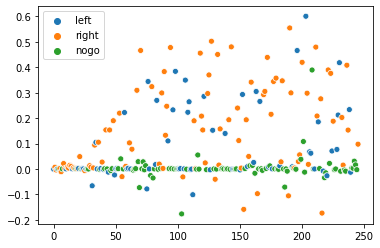

In [ ]:
sns.scatterplot(x = np.arange(U_VISam_39.factors[1][:,2].shape[0]), y = U_VISam_39.factors[1][:, 2], hue = responses_VISam_39)